# SIMULACIÓ AFEGINT EL CÀLCUL DE LA SATISFACCIÓ

AMB PARAMETRES INVENTATS:

In [ ]:
import simpy
import math
import random
import numpy as np
import pandas as pd

# VARIABLES INICIALS
durada_simulacio = 12 * 60  # 12h en minuts
PACIENTA_MITJA = 45  # paciència mitjana del client (en minuts)

# Coeficients del model de satisfacció
ALPHA = 0.0001
BETA_E = 0.5
BETA_F = 0.1
BETA_D = 0.2
BETA_M = 0.2
BETA_P = 0.1

# DADES DE LES ATRACCIONS AMB FACTORS DE SATISFACCIÓ
atraccions_info = {
    'Big Thunder Mountain': {
        'dinamica': 'blockchain',
        'persones_per_vehicle': 30, 'nombre_vehicles': 5, 'temps_durada': 4,
        'temps_mitja_espera': 43,
        'tipus': ['nivell alt'], 'posicio': (10, 90), 'desitjat': 10,
        'E': 0.3, 'F': 0.7, 'D': 0.6, 'M': 0.4, 'P': 0.8
    },
    'Dumbo the Flying Elephant': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 3, 'nombre_vehicles': 18, 'temps_durada': 2,
        'temps_mitja_espera': 25,
        'tipus': ['infantil'], 'posicio': (20, 30), 'desitjat': 7.5,
        'E': 0.8, 'F': 0.2, 'D': 0.5, 'M': 0.6, 'P': 0.4
    },
    "Peter Pan's Flight": {
        'dinamica': 'omnimover',
        'persones_per_vehicle': 4, 'nombre_vehicles': 16, 'temps_durada': 5,
        'temps_mitja_espera': 41,
        'tipus': ['infantil'], 'posicio': (25, 35), 'desitjat': 9.5,
        'E': 0.7, 'F': 0.3, 'D': 0.8, 'M': 0.5, 'P': 0.6
    },
    'Buzz Lightyear Lazer Blast': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 2, 'nombre_vehicles': 50, 'temps_durada': 4,
        'temps_mitja_espera': 30,
        'tipus': ['nivell mitja'], 'posicio': (50, 20), 'desitjat': 9,
        'E': 0.5, 'F': 0.4, 'D': 0.7, 'M': 0.3, 'P': 0.5
    },
    'Autopia': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 2, 'nombre_vehicles': 50, 'temps_durada': 5,
        'temps_mitja_espera': 27,
        'tipus': ['nivell alt'], 'posicio': (60, 70), 'desitjat': 8,
        'E': 0.4, 'F': 0.6, 'D': 0.6, 'M': 0.5, 'P': 0.7
    },
    'Phantom Manor': {
        'dinamica': 'omnimover',
        'persones_per_vehicle': 3, 'nombre_vehicles': 131, 'temps_durada': 6,
        'temps_mitja_espera': 13,
        'tipus': ['nivell mitja'], 'posicio': (5, 95), 'desitjat': 6,
        'E': 0.6, 'F': 0.5, 'D': 0.9, 'M': 0.8, 'P': 0.5
    },
    "It's a small world": {
        'dinamica': 'omnimover',
        'persones_per_vehicle': 20, 'nombre_vehicles': 24, 'temps_durada': 10,
        'temps_mitja_espera': 10,
        'tipus': ['infantil'], 'posicio': (30, 40), 'desitjat': 5.5,
        'E': 0.9, 'F': 0.2, 'D': 0.8, 'M': 0.7, 'P': 0.4
    },
    'Star Wars Hyperspace Mountain': {
        'dinamica': 'blockchain',
        'persones_per_vehicle': 32, 'nombre_vehicles': 7, 'temps_durada': 2,
        'temps_mitja_espera': 28,
        'tipus': ['nivell alt'], 'posicio': (70, 10), 'desitjat': 8.5,
        'E': 0.2, 'F': 0.8, 'D': 0.5, 'M': 0.3, 'P': 0.9
    },
    'Star Tours the Adventures Continue': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 25, 'nombre_vehicles': 4, 'temps_durada': 4,
        'temps_mitja_espera': 22,
        'tipus': ['nivell alt'], 'posicio': (75, 15), 'desitjat': 7,
        'E': 0.5, 'F': 0.5, 'D': 0.7, 'M': 0.6, 'P': 0.6
    },
    'Pirates of the Caribbean': {
        'dinamica': 'omnimover',
        'persones_per_vehicle': 17, 'nombre_vehicles': 30, 'temps_durada': 12,
        'temps_mitja_espera': 17,
        'tipus': ['nivell mitja'], 'posicio': (15, 85), 'desitjat': 50,
        'E': 0.7, 'F': 0.4, 'D': 0.8, 'M': 0.5, 'P': 0.7
    },
    'Indiana Jones et el Temple du Peril': {
        'dinamica': 'blockchain',
        'persones_per_vehicle': 30, 'nombre_vehicles': 2, 'temps_durada': 1,
        'temps_mitja_espera': 18,
        'tipus': ['nivell alt'], 'posicio': (40, 50), 'desitjat': 6.7,
        'E': 0.3, 'F': 0.7, 'D': 0.6, 'M': 0.4, 'P': 0.8
    },
    'Mad Hatter’s Tea Cups': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 6, 'nombre_vehicles': 18, 'temps_durada': 2,
        'temps_mitja_espera': 9,
        'tipus': ['infantil'], 'posicio': (35, 45), 'desitjat': 5,
        'E': 0.8, 'F': 0.1, 'D': 0.7, 'M': 0.6, 'P': 0.3
    }
}

def espera_omnimover(cua, atraccio):
    info = atraccions_info[atraccio]
    cap_vehicle = info['persones_per_vehicle']
    n_veh = info['nombre_vehicles']
    durada = info['temps_durada']
    n_clients = len(cua.queue)
    if n_clients == 0:
        return 0.0
    taxa_servei = (n_veh * cap_vehicle) / durada
    return n_clients / taxa_servei

def espera_simultanea(cua, atraccio):
    info = atraccions_info[atraccio]
    cap_total = info['persones_per_vehicle'] * info['nombre_vehicles']
    n_clients = len(cua.queue)
    if n_clients == 0:
        return 0.0
    tornades_abans = math.floor((n_clients - 1) / cap_total)
    return tornades_abans * info['temps_durada'] + info['temps_durada']

def espera_blockchain(cua, atraccio):
    info = atraccions_info[atraccio]
    cap_vehicle = info['persones_per_vehicle']
    n_vehicles  = info['nombre_vehicles']
    durada_via  = info['temps_durada']
    capacitat_total = cap_vehicle * n_vehicles
    headway = durada_via / n_vehicles
    n_clients = len(cua.queue)
    if n_clients == 0:
        return 0.0
    rotacions = math.ceil(n_clients / cap_vehicle)
    espera_per_cua = headway * (rotacions - 1) * cap_vehicle / cap_vehicle
    return espera_per_cua + durada_via

def calcula_espera(cua, atraccio):
    dinamica = atraccions_info[atraccio]['dinamica']
    if dinamica == 'simultanea':
        return espera_simultanea(cua, atraccio)
    elif dinamica == 'omnimover':
        return espera_omnimover(cua, atraccio)
    elif dinamica == 'blockchain':
        return espera_blockchain(cua, atraccio)
    else:
        raise ValueError(f"Tipus de dinàmica desconeguda: {dinamica}")

def generar_preferencies():
    preferencies_tipus = ['infantil', 'nivell alt', 'nivell mitja']
    return random.sample(preferencies_tipus, random.randint(1, 3))

def distancia(pos1, pos2):
    return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

# Funció client modificada per incloure satisfacció
def client(env, nom, cues, dades, paciencia, preferencies):
    registre = {
        'Client': nom,
        'Paciencia': paciencia,
        'Atraccions': [],
        'TempsArribades': [],
        'EsperesReals': [],
        'Abandonaments': 0,
        'TempsTotal': 0,
        'Valoracions': {},
        'Preferencies': preferencies,
        'Satisfaccio': 10.0  # Inicialitzar satisfacció
    }
    
    temps_inici = env.now
    posicio_actual = (0, 0)
    posicions_clients[nom] = {'pos': posicio_actual, 'estat': 'moviment'}
    
    matching_atraccions = [
        a for a in atraccions_info 
        if any(tipus in atraccions_info[a]['tipus'] for tipus in preferencies)
    ]
    
    atraccions_pendents = []

    if matching_atraccions:
        n = random.randint(6, 10)
        n = min(n, len(matching_atraccions))

        attractions = matching_atraccions.copy()
        weights  = np.array([atraccions_info[a]['desitjat'] for a in attractions], dtype=float)
        weights = weights / weights.sum()
        selected_idx = np.random.choice(len(attractions), size=n, replace=False, p=weights)
        atraccions_pendents = [attractions[i] for i in selected_idx]
    
    atraccions_abandonades = []
    ks=[]
    
    while (atraccions_pendents or atraccions_abandonades) and env.now - temps_inici <= durada_simulacio:
        if atraccions_pendents:
            llista_actual = atraccions_pendents
        else:
            llista_actual = atraccions_abandonades
        
        esperes = {a: calcula_espera(cues[a], a) for a in llista_actual}
        millor_espera = min(esperes.values())
        candidats = [a for a in esperes if esperes[a] == millor_espera]
        atraccio = min(candidats, key=lambda a: distancia(posicio_actual, atraccions_info[a]['posicio'])) if len(candidats) > 1 else candidats[0]
        
        if esperes[atraccio] > paciencia:
            if atraccio in atraccions_pendents:
                atraccions_pendents.remove(atraccio)
                atraccions_abandonades.append(atraccio)
            elif atraccio in atraccions_abandonades:
                atraccions_abandonades.remove(atraccio)
            registre['Abandonaments'] += 1
            registre['Atraccions'].append(f"{atraccio} (X)")
            registre['TempsArribades'].append(env.now)
            registre['EsperesReals'].append(paciencia)
            # Actualitzar satisfacció per abandonament
            temps_a_cua = paciencia
            info = atraccions_info[atraccio]
            tw_factor = (1 - BETA_E * info['E'] + BETA_F * info['F'] - BETA_D * info['D'] - BETA_M * info['M'] + BETA_P * info['P'])
            delta = ALPHA * (temps_a_cua ** 2 / 2) * tw_factor
            registre['Satisfaccio'] *= math.exp(-delta)
            registre['Valoracions'][f"{atraccio} (X)"] = registre['Satisfaccio']
            posicions_clients[nom]['estat'] = 'abandonat'
            continue
        
        distancia_mou = distancia(posicio_actual, atraccions_info[atraccio]['posicio'])
        temps_moviment = max(1, int(distancia_mou / 5))
        yield env.timeout(temps_moviment)
        temps_arribada = env.now
        posicio_actual = atraccions_info[atraccio]['posicio']
        posicions_clients[nom]['pos'] = posicio_actual
        posicions_clients[nom]['estat'] = 'cua'
        
        start_wait = env.now
        if atraccions_info[atraccio]['dinamica'] == 'simultanea':
            with cues[atraccio].request() as req:
                result = yield req | env.timeout(paciencia)
                stop_wait = env.now
                if req in result:
                    yield env.timeout(atraccions_info[atraccio]['temps_durada'])
        elif atraccions_info[atraccio]['dinamica'] == 'omnimover':
            with cues[atraccio].request() as req:
                result = yield req | env.timeout(paciencia)
                if req in result:
                    yield env.timeout(0.5)
                    stop_wait = env.now
                    yield env.timeout(atraccions_info[atraccio]['temps_durada'])
        else:
            with cues[atraccio].request() as req:
                result = yield req | env.timeout(paciencia)
                stop_wait = env.now
                if req in result:
                    yield env.timeout(atraccions_info[atraccio]['temps_durada'])
        
        temps_a_cua = stop_wait - start_wait if req in result else paciencia
        
        if req not in result:
            if atraccio in atraccions_pendents:
                atraccions_pendents.remove(atraccio)
                atraccions_abandonades.append(atraccio)
            registre['Abandonaments'] += 1
            registre['Atraccions'].append(f"{atraccio} (X)")
            registre['TempsArribades'].append(env.now)
            registre['EsperesReals'].append(temps_a_cua)
            # Actualitzar satisfacció
            info = atraccions_info[atraccio]
            tw_factor = (1 - BETA_E * info['E'] + BETA_F * info['F'] - BETA_D * info['D'] - BETA_M * info['M'] + BETA_P * info['P'])
            delta = ALPHA * (temps_a_cua ** 2 / 2) * tw_factor
            registre['Satisfaccio'] *= math.exp(-delta)
            registre['Valoracions'][f"{atraccio} (X)"] = registre['Satisfaccio']
            posicions_clients[nom]['estat'] = 'abandonat'
            continue
        
        # Actualitzar satisfacció després de l'espera
        info = atraccions_info[atraccio]
        tw_factor = (1 - BETA_E * info['E'] + BETA_F * info['F'] - BETA_D * info['D'] - BETA_M * info['M'] + BETA_P * info['P'])
        delta = ALPHA * (temps_a_cua ** 2 / 2) * tw_factor
        registre['Satisfaccio'] *= math.exp(-delta)
        registre['Valoracions'][atraccio] = registre['Satisfaccio']
        
        registre['EsperesReals'].append(temps_a_cua)
        registre['Atraccions'].append(atraccio)
        registre['TempsArribades'].append(temps_arribada)

        posicions_clients[nom]['estat'] = 'moviment'
        if atraccio in atraccions_pendents:
            atraccions_pendents.remove(atraccio)

    temps_final = env.now
    registre['TempsTotal'] = temps_final - temps_inici
    dades.append(registre)

In [37]:
def prepara_clients(total_clients):
    clients = []
    for i in range(total_clients):
        paciencia = max(5, np.random.normal(PACIENTA_MITJA, 10))
        preferencies = generar_preferencies()
        clients.append((f'Client_{i:05d}', paciencia, preferencies))
    return clients

posicions_clients = {}

def run_simulacio():
    env = simpy.Environment()
    cues = {}
    for nom, info in atraccions_info.items():
        if info['dinamica'] == 'simultanea':
            capacity = info['persones_per_vehicle'] * info['nombre_vehicles']
        elif info['dinamica'] == 'omnimover':
            capacity = info['persones_per_vehicle'] * info['nombre_vehicles']
        else:#(blockchain)
            capacity = info['persones_per_vehicle']
        cues[nom] = simpy.Resource(env, capacity=capacity)

    dades = []

    # Prepara tots els clients abans de començar
    total_clients = 12000
    clients = prepara_clients(total_clients)

    for client_id, paciencia, preferencies in clients:
        env.process(client(
            env,
            client_id,
            cues,
            dades,
            paciencia,
            preferencies
        ))

    env.run()
    return pd.DataFrame(dades)

# Execució principal
df_aleatori = run_simulacio()

In [38]:
df_aleatori.to_csv("resultats_simulacio.csv", index=False)
print(df_aleatori[['Client', 'Satisfaccio', 'Abandonaments', 'TempsTotal']].describe())

        Satisfaccio  Abandonaments    TempsTotal
count  12000.000000   12000.000000  12000.000000
mean       6.777308       3.685250    487.782001
std        2.120745       4.918201    269.979401
min        2.912801       0.000000     25.500000
25%        4.887544       0.000000    222.067054
50%        7.268052       2.000000    721.147297
75%        8.628691       4.000000    736.000000
max        9.999880      32.000000    773.000000


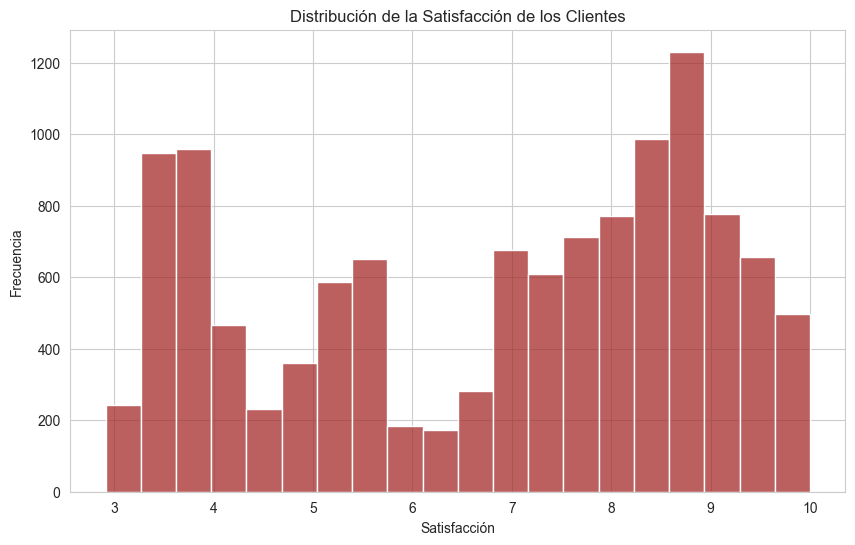

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma de satisfacció
plt.figure(figsize=(10, 6))
sns.histplot(df_aleatori['Satisfaccio'], kde=False, bins=20, color='brown')
plt.title('Distribución de la Satisfacción de los Clientes')
plt.xlabel('Satisfacción')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

SIMPLIFICANT EL MODEL A UNA k GENERAL PER ATRACCIÓ (TROBADES INFERINT ELS VALORS DEL FACTOR TW (K) MITJANÇANT GRID SEARCH, mirar fitxer inferencia.py):

In [ ]:
import simpy
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

# ---------- Paràmetres globals ----------
DURADA_SIMULACIO = 12 * 60  # 12h en minuts
PACIENTA_MITJA = 45 # paciència mitjana del client (en minuts)
ALPHA = 0.0001  # coeficient fix de la fórmula

# ---------- Dades de les atraccions ----------
#Valors de la k optima trobats per cada atracció:
k_vals = {
    'Big Thunder Mountain': 0.228571,
    'Dumbo the Flying Elephant': 0.9754,
    "Peter Pan's Flight": 0.9631,
    'Buzz Lightyear Lazer Blast': 0.935714,
    'Autopia': 0.9385,
    'Phantom Manor': 0.9262,
    "It's a small world": 0.421429,
    'Star Wars Hyperspace Mountain': 0.1,
    'Star Tours the Adventures Continue': 0.742857,
    'Pirates of the Caribbean': 0.1,
    'Indiana Jones et el Temple du Peril': 0.1,
    'Mad Hatter’s Tea Cups': 0.614286
}

atraccions_info = {
    'Big Thunder Mountain': {
        'dinamica': 'blockchain',
        'persones_per_vehicle': 30, 'nombre_vehicles': 5, 'temps_durada': 4,
        'temps_mitja_espera': 43,
        'tipus': ['nivell alt'], 'posicio': (10, 90), 'desitjat': 10
    },
    'Dumbo the Flying Elephant': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 3, 'nombre_vehicles': 18, 'temps_durada': 2,
        'temps_mitja_espera': 25,
        'tipus': ['infantil'], 'posicio': (20, 30), 'desitjat': 7.5
    },
    "Peter Pan's Flight": {
        'dinamica': 'omnimover',
        'persones_per_vehicle': 4, 'nombre_vehicles': 16, 'temps_durada': 5,
        'temps_mitja_espera': 41,
        'tipus': ['infantil'], 'posicio': (25, 35), 'desitjat': 9.5
    },
    'Buzz Lightyear Lazer Blast': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 2, 'nombre_vehicles': 50, 'temps_durada': 4,
        'temps_mitja_espera': 30,
        'tipus': ['nivell mitja'], 'posicio': (50, 20), 'desitjat': 9
    },
    'Autopia': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 2, 'nombre_vehicles': 50, 'temps_durada': 5,
        'temps_mitja_espera': 27,
        'tipus': ['nivell alt'], 'posicio': (60, 70), 'desitjat': 8
    },
    'Phantom Manor': {
        'dinamica': 'omnimover',
        'persones_per_vehicle': 3, 'nombre_vehicles': 131, 'temps_durada': 6,
        'temps_mitja_espera': 13,
        'tipus': ['nivell mitja'], 'posicio': (5, 95), 'desitjat': 6
    },
    "It's a small world": {
        'dinamica': 'omnimover',
        'persones_per_vehicle': 20, 'nombre_vehicles': 24, 'temps_durada': 10,
        'temps_mitja_espera': 10,
        'tipus': ['infantil'], 'posicio': (30, 40), 'desitjat': 5.5
    },
    'Star Wars Hyperspace Mountain': {
        'dinamica': 'blockchain',
        'persones_per_vehicle': 32, 'nombre_vehicles': 7, 'temps_durada': 2,
        'temps_mitja_espera': 28,
        'tipus': ['nivell alt'], 'posicio': (70, 10), 'desitjat': 8.5
    },
    'Star Tours the Adventures Continue': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 25, 'nombre_vehicles': 4, 'temps_durada': 4,
        'temps_mitja_espera': 22,
        'tipus': ['nivell alt'], 'posicio': (75, 15), 'desitjat': 7
    },
    'Pirates of the Caribbean': {
        'dinamica': 'omnimover',
        'persones_per_vehicle': 17, 'nombre_vehicles': 30, 'temps_durada': 12,
        'temps_mitja_espera': 17,
        'tipus': ['nivell mitja'], 'posicio': (15, 85), 'desitjat': 50
    },
    'Indiana Jones et el Temple du Peril': {
        'dinamica': 'blockchain',
        'persones_per_vehicle': 30, 'nombre_vehicles': 2, 'temps_durada': 1,
        'temps_mitja_espera': 18,
        'tipus': ['nivell alt'], 'posicio': (40, 50), 'desitjat': 6.7
    },
    'Mad Hatter’s Tea Cups': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 6, 'nombre_vehicles': 18, 'temps_durada': 2,
        'temps_mitja_espera': 9,
        'tipus': ['infantil'], 'posicio': (35, 45), 'desitjat': 5
    }
}

# ---------- Funcions d'espera ----------

def espera_omnimover(cua, atraccio):
    info = atraccions_info[atraccio]
    cap_vehicle = info['persones_per_vehicle']
    n_veh = info['nombre_vehicles']
    durada = info['temps_durada']
    n_clients = len(cua.queue)
    if n_clients == 0:
        return 0.0
    taxa_servei = (n_veh * cap_vehicle) / durada
    return n_clients / taxa_servei

def espera_simultanea(cua, atraccio):
    info = atraccions_info[atraccio]
    cap_total = info['persones_per_vehicle'] * info['nombre_vehicles']
    n_clients = len(cua.queue)
    if n_clients == 0:
        return 0.0
    tornades_abans = math.floor((n_clients - 1) / cap_total)
    return tornades_abans * info['temps_durada'] + info['temps_durada']

def espera_blockchain(cua, atraccio):
    info = atraccions_info[atraccio]
    cap_vehicle = info['persones_per_vehicle']
    n_vehicles  = info['nombre_vehicles']
    durada_via  = info['temps_durada']
    capacitat_total = cap_vehicle * n_vehicles
    headway = durada_via / n_vehicles
    n_clients = len(cua.queue)
    if n_clients == 0:
        return 0.0
    rotacions = math.ceil(n_clients / cap_vehicle)
    espera_per_cua = headway * (rotacions - 1) * cap_vehicle / cap_vehicle
    return espera_per_cua + durada_via

def calcula_espera(cua, atraccio):
    dinamica = atraccions_info[atraccio]['dinamica']
    if dinamica == 'simultanea':
        return espera_simultanea(cua, atraccio)
    elif dinamica == 'omnimover':
        return espera_omnimover(cua, atraccio)
    elif dinamica == 'blockchain':
        return espera_blockchain(cua, atraccio)
    else:
        raise ValueError(f"Tipus de dinàmica desconeguda: {dinamica}")


# ---------- Generació de clients ----------
def generar_preferencies():
    tipus = ['infantil', 'nivell alt', 'nivell mitja']
    return random.sample(tipus, random.randint(1, 3))

def distancia(p1, p2):
    return math.hypot(p1[0]-p2[0], p1[1]-p2[1])

# ---------- Procés client ----------
def client(env, nom, cues, dades, paciencia, preferencies, k):
    registre = {
        'Client': nom,
        'Paciencia': paciencia,
        'Atraccions': [],
        'TempsArribades': [],
        'EsperesReals': [],
        'Abandonaments': 0,
        'TempsTotal': 0,
        'Valoracions': {},
        'Preferencies': preferencies,
        'Satisfaccio': 10.0
    }
    
    temps_inici = env.now
    posicio_actual = (0, 0)
    posicions_clients[nom] = {'pos': posicio_actual, 'estat': 'moviment'}
    
    matching_atraccions = [
        a for a in atraccions_info 
        if any(tipus in atraccions_info[a]['tipus'] for tipus in preferencies)
    ]
    
    atraccions_pendents = []

    if matching_atraccions:
        n = random.randint(6, 10)
        n = min(n, len(matching_atraccions))

        attractions = matching_atraccions.copy()
        weights  = np.array([atraccions_info[a]['desitjat'] for a in attractions], dtype=float)
        weights = weights / weights.sum()
        selected_idx = np.random.choice(len(attractions), size=n, replace=False, p=weights)
        atraccions_pendents = [attractions[i] for i in selected_idx]
    
    atraccions_abandonades = []
    
    while (atraccions_pendents or atraccions_abandonades) and env.now - temps_inici <= durada_simulacio:
        if atraccions_pendents:
            llista_actual = atraccions_pendents
        else:
            llista_actual = atraccions_abandonades
        
        esperes = {a: calcula_espera(cues[a], a) for a in llista_actual}
        millor_espera = min(esperes.values())
        candidats = [a for a in esperes if esperes[a] == millor_espera]
        atraccio = min(candidats, key=lambda a: distancia(posicio_actual, atraccions_info[a]['posicio'])) if len(candidats) > 1 else candidats[0]
        
        if esperes[atraccio] > paciencia:
            if atraccio in atraccions_pendents:
                atraccions_pendents.remove(atraccio)
                atraccions_abandonades.append(atraccio)
            elif atraccio in atraccions_abandonades:
                atraccions_abandonades.remove(atraccio)
            registre['Abandonaments'] += 1
            registre['Atraccions'].append(f"{atraccio} (X)")
            registre['TempsArribades'].append(env.now)
            registre['EsperesReals'].append(paciencia)
            temps_a_cua = paciencia
            info = atraccions_info[atraccio]
            tw_factor = k[atraccio]
            delta = ALPHA * (temps_a_cua ** 2 / 2) * tw_factor
            registre['Satisfaccio'] *= math.exp(-delta)
            registre['Valoracions'][atraccio] = registre['Satisfaccio']
            posicions_clients[nom]['estat'] = 'abandonat'
            continue
        
        distancia_mou = distancia(posicio_actual, atraccions_info[atraccio]['posicio'])
        temps_moviment = max(1, int(distancia_mou / 5))
        yield env.timeout(temps_moviment)
        temps_arribada = env.now
        posicio_actual = atraccions_info[atraccio]['posicio']
        posicions_clients[nom]['pos'] = posicio_actual
        posicions_clients[nom]['estat'] = 'cua'
        
        start_wait = env.now
        if atraccions_info[atraccio]['dinamica'] == 'simultanea':
            with cues[atraccio].request() as req:
                result = yield req | env.timeout(paciencia)
                stop_wait = env.now
                if req in result:
                    yield env.timeout(atraccions_info[atraccio]['temps_durada'])
        elif atraccions_info[atraccio]['dinamica'] == 'omnimover':
            with cues[atraccio].request() as req:
                result = yield req | env.timeout(paciencia)
                if req in result:
                    yield env.timeout(0.5)
                    stop_wait = env.now
                    yield env.timeout(atraccions_info[atraccio]['temps_durada'])
        else:
            with cues[atraccio].request() as req:
                result = yield req | env.timeout(paciencia)
                stop_wait = env.now
                if req in result:
                    yield env.timeout(atraccions_info[atraccio]['temps_durada'])
        
        temps_a_cua = stop_wait - start_wait if req in result else paciencia
        
        if req not in result:
            if atraccio in atraccions_pendents:
                atraccions_pendents.remove(atraccio)
                atraccions_abandonades.append(atraccio)
            registre['Abandonaments'] += 1
            registre['Atraccions'].append(f"{atraccio} (X)")
            registre['TempsArribades'].append(env.now)
            registre['EsperesReals'].append(temps_a_cua)
            # Actualitzar satisfacció
            info = atraccions_info[atraccio]
            tw_factor = k[atraccio]
            delta = ALPHA * (temps_a_cua ** 2 / 2) * tw_factor
            registre['Satisfaccio'] *= math.exp(-delta)
            registre['Valoracions'][atraccio] = registre['Satisfaccio']
            posicions_clients[nom]['estat'] = 'abandonat'
            continue
        
        # Actualitzar satisfacció després de l'espera
        info = atraccions_info[atraccio]
        tw_factor = k[atraccio]
        delta = ALPHA * (temps_a_cua ** 2 / 2) * tw_factor
        registre['Satisfaccio'] *= math.exp(-delta)
        registre['Valoracions'][atraccio] = registre['Satisfaccio']
        
        registre['EsperesReals'].append(temps_a_cua)
        registre['Atraccions'].append(atraccio)
        registre['TempsArribades'].append(temps_arribada)

        posicions_clients[nom]['estat'] = 'moviment'
        if atraccio in atraccions_pendents:
            atraccions_pendents.remove(atraccio)

    # Final del recorregut
    temps_final = env.now
    registre['TempsTotal'] = temps_final - temps_inici
    dades.append(registre)

# ---------- Simulació ----------
def prepara_clients(total_clients):
    clients = []
    for i in range(total_clients):
        paciencia = max(5, np.random.normal(PACIENTA_MITJA, 10))
        preferencies = generar_preferencies()
        clients.append((f'Client_{i:05d}', paciencia, preferencies))
    return clients

posicions_clients = {}

def run_simulacio(k):
    env = simpy.Environment()
    cues = {}
    for nom, info in atraccions_info.items():
        if info['dinamica'] == 'simultanea':
            capacity = info['persones_per_vehicle'] * info['nombre_vehicles']
        elif info['dinamica'] == 'omnimover':
            capacity = info['persones_per_vehicle'] * info['nombre_vehicles']
        else:#(blockchain)
            capacity = info['persones_per_vehicle']
        cues[nom] = simpy.Resource(env, capacity=capacity)

    dades = []

    # Prepara tots els clients abans de començar
    total_clients = 12000
    clients = prepara_clients(total_clients)

    for client_id, paciencia, preferencies in clients:
        env.process(client(
            env,
            client_id,
            cues,
            dades,
            paciencia,
            preferencies,k
        ))

    env.run()
    return pd.DataFrame(dades)

In [ ]:
df = run_simulacio(k_vals)
df.to_csv("resultats_simulacio.csv", index=False)
print(df[['Client', 'Satisfaccio', 'Abandonaments', 'TempsTotal']].describe())

        Satisfaccio  Abandonaments    TempsTotal
count  12000.000000   12000.000000  12000.000000
mean       7.459749       3.829167    488.957968
std        1.893597       4.946836    271.681213
min        2.630330       0.000000     25.500000
25%        6.739230       0.000000    214.500000
50%        7.843486       2.000000    722.000000
75%        8.905177       4.000000    737.000000
max        9.999872      30.000000    773.000000


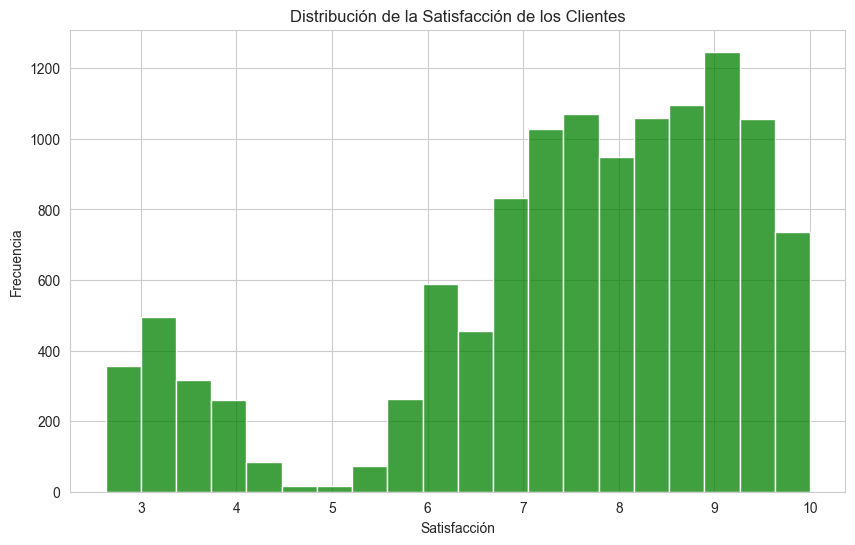

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma de satisfacció
plt.figure(figsize=(10, 6))
sns.histplot(df['Satisfaccio'], kde=False, bins=20, color='green')
plt.title('Distribución de la Satisfacción de los Clientes')
plt.xlabel('Satisfacción')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

C:\Users\nerea\AppData\Local\Temp\ipykernel_9128\3385365413.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Atraccion', y='Satisfaccion_Media', data=df_medias, palette='viridis')


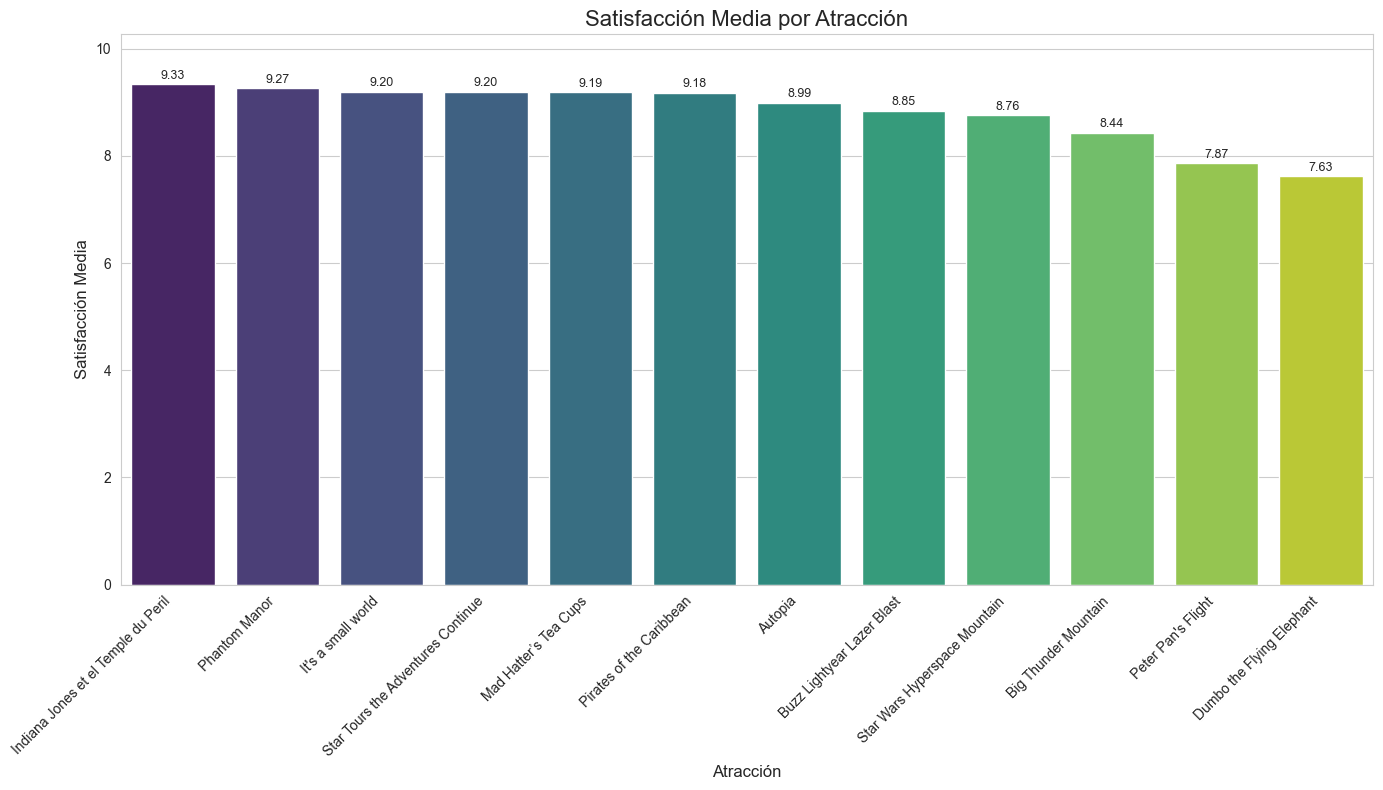

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

    
# Calcular la satisfacció mitjana per atracció
satisfaccion_por_atraccion = {}

for _, cliente in df.iterrows():
    valoraciones = cliente['Valoracions']
    
    for atraccion, valor in valoraciones.items():
        if atraccion not in satisfaccion_por_atraccion:
            satisfaccion_por_atraccion[atraccion] = []
        satisfaccion_por_atraccion[atraccion].append(valor)

medias = {atraccion: sum(valores)/len(valores) 
            for atraccion, valores in satisfaccion_por_atraccion.items() 
            if valores}  # Evitar divisiones por cero

df_medias = pd.DataFrame({
    'Atraccion': list(medias.keys()),
    'Satisfaccion_Media': list(medias.values())
})

df_medias = df_medias.sort_values('Satisfaccion_Media', ascending=False)


def graficar_satisfaccion(df_medias):
    plt.figure(figsize=(14, 8))
    sns.set_style("whitegrid")
    
    ax = sns.barplot(x='Atraccion', y='Satisfaccion_Media', data=df_medias, palette='viridis')
    
    plt.title('Satisfacción Media por Atracción', fontsize=16)
    plt.xlabel('Atracción', fontsize=12)
    plt.ylabel('Satisfacción Media', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    for i, v in enumerate(df_medias['Satisfaccion_Media']):
        ax.text(i, v + 0.1, f'{v:.2f}', ha='center', fontsize=9)
    
    plt.ylim(0, max(df_medias['Satisfaccion_Media']) * 1.1)
    
    plt.savefig('satisfaccion_por_atraccion.png', dpi=300, bbox_inches='tight')
    plt.show()

graficar_satisfaccion(df_medias)

# ÁNALISI DELS RESULTATS

ESTADÍSTIQUES PER UNA ATRACCIÓ CONCRETA:

Ejecutando simulación para analizar la distribución de satisfacción en Big Thunder Mountain...

Estadísticas de Satisfacción para Big Thunder Mountain:
Número de clientes: 6947
Media: 8.46
Mediana: 8.61
Desviación estándar: 1.05
Mínimo: 5.68
Máximo: 10.00


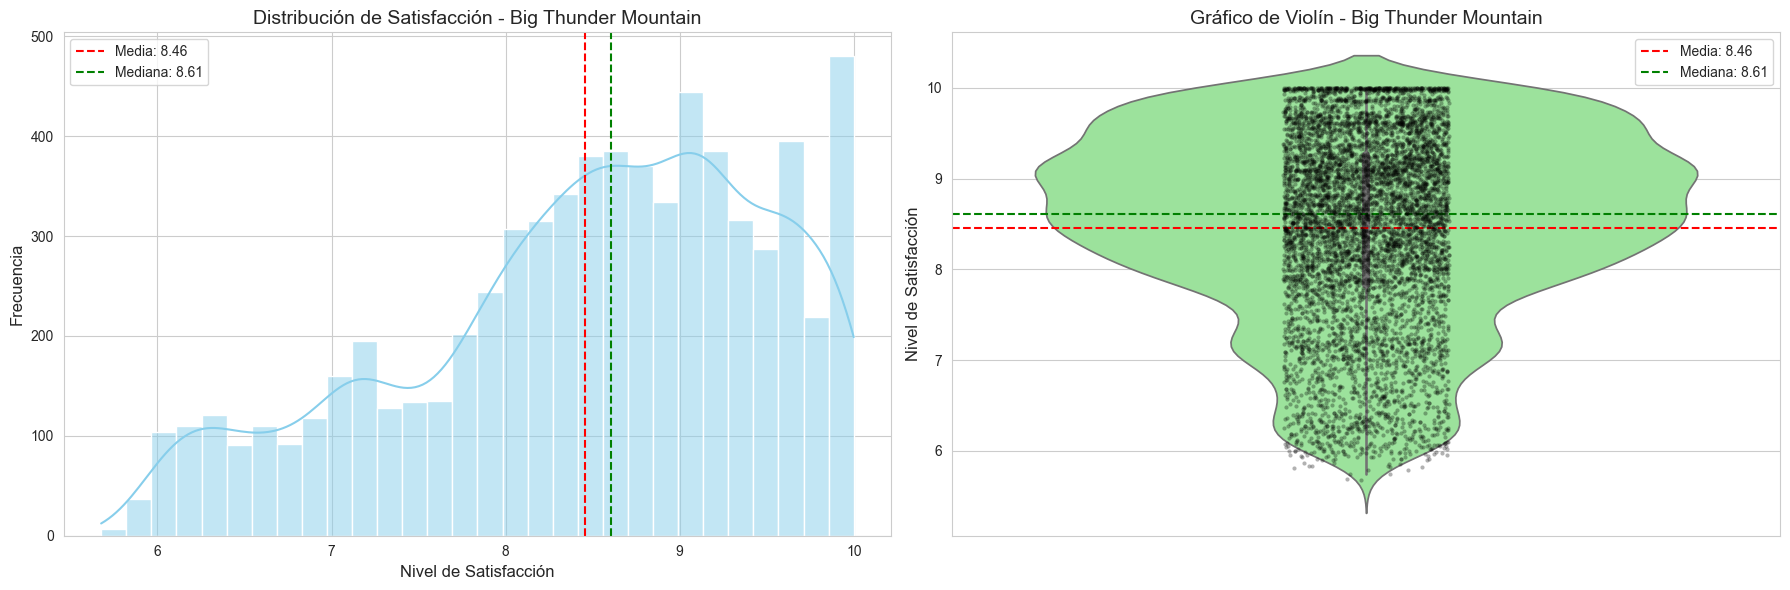


Recopilando datos de otras atracciones para comparación...


C:\Users\nerea\AppData\Local\Temp\ipykernel_9128\1779446873.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Atracción', y='Satisfacción', data=df_comparacion, palette='Set3')


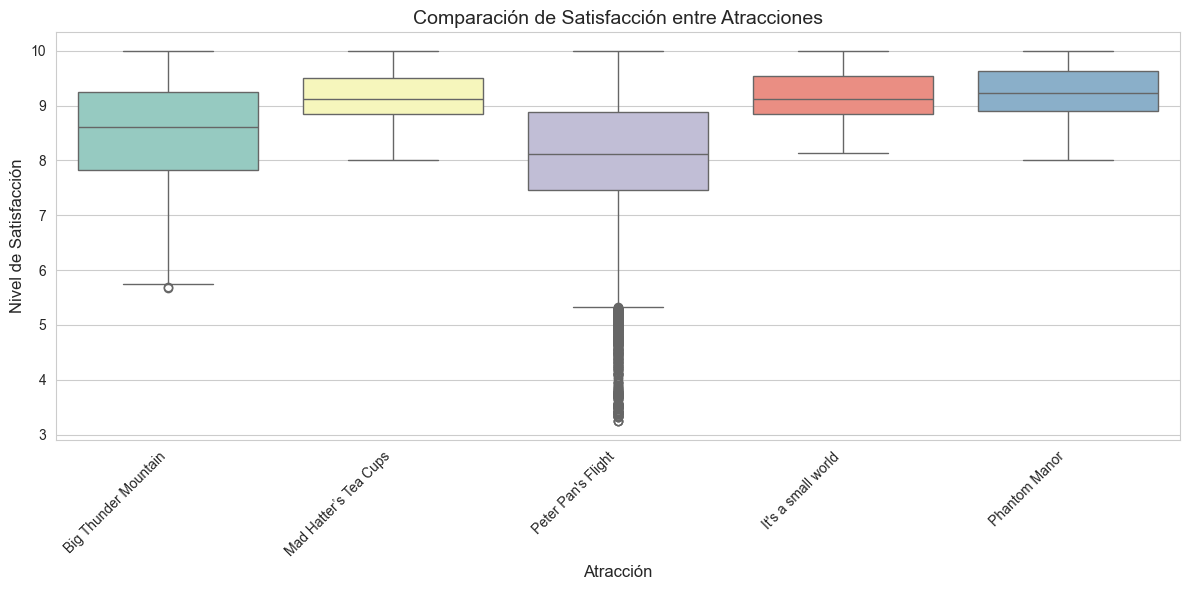

[9.997015033090046,
 9.977096311690138,
 9.98885830236051,
 9.996842020121848,
 9.77142475500776,
 9.994201692168772,
 9.994201692168772,
 9.998419173963718,
 9.946692669043856,
 9.637451245161651,
 9.861722767440199,
 9.108003617428963,
 9.80942833082582,
 9.909301466387861,
 9.909301466387861,
 9.909809326023158,
 9.909809326023158,
 9.640778219626862,
 9.895717396237275,
 9.973093662111808,
 9.846930950688282,
 9.773002547197844,
 9.54643040251045,
 9.712809310586803,
 9.793234331596508,
 9.984201888924265,
 9.928251337865378,
 9.984229797428398,
 9.987081578099518,
 9.979066608095106,
 9.994201692168772,
 9.994201692168772,
 9.958167812873716,
 9.773280700518736,
 9.975741896573552,
 9.625238816732418,
 9.978553764661985,
 9.979202792035553,
 9.97965646158521,
 9.979066608095106,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 9.998921488663518,
 9.998921488663518,
 9.998921488663518,
 9.998921488663518,

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analizar_distribucion_satisfaccion(nombre_atraccion="Big Thunder Mountain"):
    print(f"Ejecutando simulación para analizar la distribución de satisfacción en {nombre_atraccion}...")
    
    resultados = run_simulacio(k_vals)
    valores_satisfaccion = []
    
    for _, cliente in resultados.iterrows():
        valoraciones = cliente['Valoracions']
        
        if nombre_atraccion in valoraciones:
            valores_satisfaccion.append(valoraciones[nombre_atraccion])
    
    if valores_satisfaccion:
        n_clientes = len(valores_satisfaccion)
        media = np.mean(valores_satisfaccion)
        mediana = np.median(valores_satisfaccion)
        desv_est = np.std(valores_satisfaccion)
        minimo = min(valores_satisfaccion)
        maximo = max(valores_satisfaccion)
        
        print(f"\nEstadísticas de Satisfacción para {nombre_atraccion}:")
        print(f"Número de clientes: {n_clientes}")
        print(f"Media: {media:.2f}")
        print(f"Mediana: {mediana:.2f}")
        print(f"Desviación estándar: {desv_est:.2f}")
        print(f"Mínimo: {minimo:.2f}")
        print(f"Máximo: {maximo:.2f}")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
        
        sns.histplot(valores_satisfaccion, kde=True, ax=ax1, bins=30, color='skyblue')
        ax1.set_title(f'Distribución de Satisfacción - {nombre_atraccion}', fontsize=14)
        ax1.set_xlabel('Nivel de Satisfacción', fontsize=12)
        ax1.set_ylabel('Frecuencia', fontsize=12)
        ax1.axvline(media, color='red', linestyle='--', label=f'Media: {media:.2f}')
        ax1.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.2f}')
        ax1.legend()
        
        sns.violinplot(y=valores_satisfaccion, ax=ax2, color='lightgreen')
        sns.stripplot(y=valores_satisfaccion, ax=ax2, size=3, color='black', alpha=0.3)
        ax2.set_title(f'Gráfico de Violín - {nombre_atraccion}', fontsize=14)
        ax2.set_ylabel('Nivel de Satisfacción', fontsize=12)
        
        ax2.axhline(y=media, color='red', linestyle='--', label=f'Media: {media:.2f}')
        ax2.axhline(y=mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.2f}')
        ax2.legend()
        
        plt.tight_layout()
        plt.savefig(f'distribucion_satisfaccion_{nombre_atraccion.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\nRecopilando datos de otras atracciones para comparación...")
        comparacion_atracciones = {}
        comparacion_atracciones[nombre_atraccion] = valores_satisfaccion
        
        otras_atracciones = list(k_vals.keys())
        otras_atracciones.remove(nombre_atraccion)
        otras_atracciones = np.random.choice(otras_atracciones, min(4, len(otras_atracciones)), replace=False)
        
        for otra_atraccion in otras_atracciones:
            valores_otra = []
            for _, cliente in resultados.iterrows():
                if otra_atraccion in cliente['Valoracions']:
                    valores_otra.append(cliente['Valoracions'][otra_atraccion])
            if valores_otra:  # Solo añadir si hay valores
                comparacion_atracciones[otra_atraccion] = valores_otra
        
        datos_comparacion = []
        for atraccion, valores in comparacion_atracciones.items():
            for valor in valores:
                datos_comparacion.append({'Atracción': atraccion, 'Satisfacción': valor})
                
        df_comparacion = pd.DataFrame(datos_comparacion)
        
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Atracción', y='Satisfacción', data=df_comparacion, palette='Set3')
        plt.title('Comparación de Satisfacción entre Atracciones', fontsize=14)
        plt.xlabel('Atracción', fontsize=12)
        plt.ylabel('Nivel de Satisfacción', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f'comparacion_satisfaccion_{nombre_atraccion.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return valores_satisfaccion
    else:
        print(f"No se encontraron valoraciones para la atracción {nombre_atraccion}")
        return None

# Executem l'anàlisi per Big Thunder Mountain
analizar_distribucion_satisfaccion("Big Thunder Mountain")